# Explorations

Visualise the data collected.


In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
os.chdir("../")  # Root of the project
from matplotlib import pyplot as plt
from data_preprocessing.create_dataset import DatasetCreator

In [2]:
path_clean = "data/clean/"

## Labels

In [3]:
data = DatasetCreator(batch_size=128, sequence_length=10)
data.add_folder(path_clean)

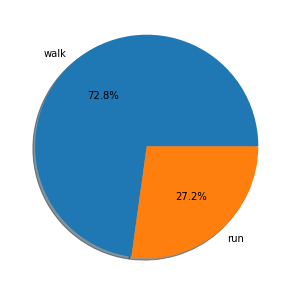

In [4]:
plt.pie([data.y.shape[0] - np.sum(data.y), np.sum(data.y)], labels=('walk', "run"), shadow=True, autopct='%1.1f%%')
fig = plt.gcf()
fig.set_size_inches(5, 6)

## Sampling rate

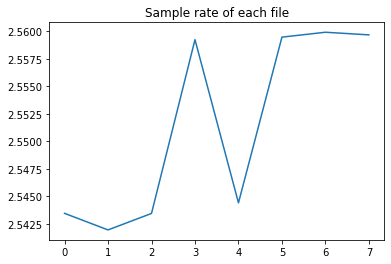

In [5]:
z = []
for file in os.listdir(path_clean):
    if not "nothing" in file:
        _ = pd.read_csv(os.path.join(path_clean, file))
        z += [_.shape[0]/float((pd.to_datetime(_.date.max()) -pd.to_datetime(_.date.min()))/np.timedelta64(1, 's'))]
plt.plot(z)
_ = plt.title("Sample rate of each file")

Sampling rate : 2.5Hz


## Acceleration

In [6]:
def load_all(string):
    """Load of the delimted file with 'string' in theire name"""
    files = glob("data/clean/*_" + string + ".txt")
    output = run = pd.read_csv(files[0])
    for _ in files[1:]:
        output = output.append(pd.read_csv(_))
    
    return output

In [7]:
plt.rcParams['figure.figsize'] = (20, 8)

run = load_all("run")
walk = load_all("walk")
nothing = load_all("nothing")

In [8]:
run["acceleration"] = np.sqrt( np.square(run.x) + np.square(run.y)+ np.square(run.z))
walk["acceleration"] = np.sqrt( np.square(walk.x) + np.square(walk.y)+ np.square(walk.z))
nothing["acceleration"] = np.sqrt( np.square(nothing.x) + np.square(nothing.y)+ np.square(nothing.z))

### Moving average

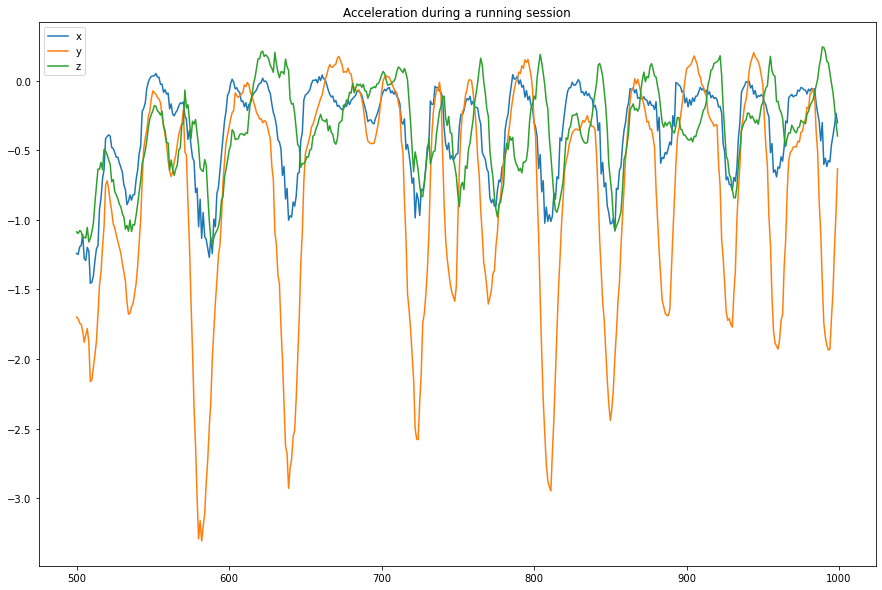

In [9]:
plt.rcParams['figure.figsize'] = (15, 10)
_ = plt.plot(run.x.rolling(10).mean()[500:1000], label="x")
_ = plt.plot(run.y.rolling(10).mean()[500:1000], label="y")
_ = plt.plot(run.z.rolling(10).mean()[500:1000], label="z")
_ = plt.legend()
_ = plt.title("Acceleration during a running session")

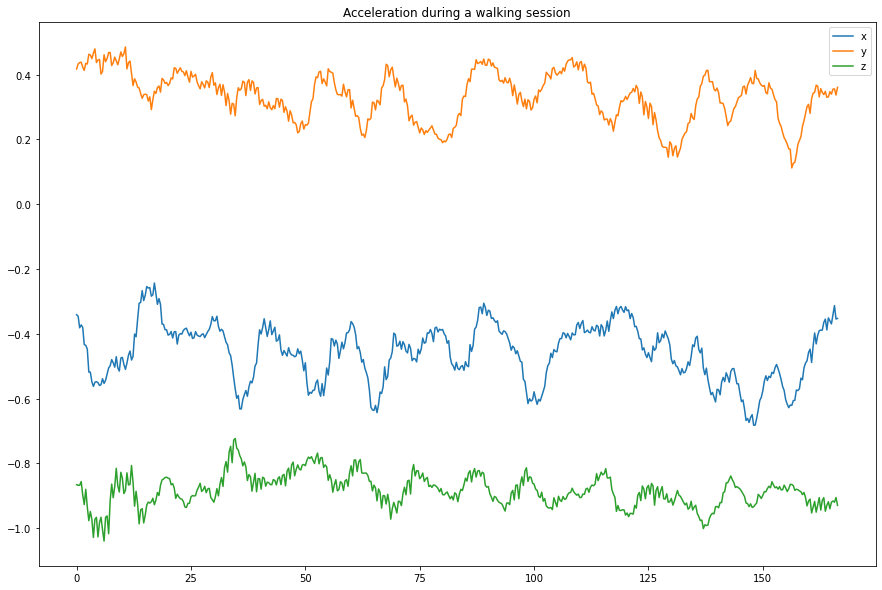

In [10]:
plt.rcParams['figure.figsize'] = (15, 10)
time = np.arange(500)/3
_ = plt.plot(time, walk.x.rolling(15).mean()[500:1000], label="x")
_ = plt.plot(time, walk.y.rolling(15).mean()[500:1000], label="y")
_ = plt.plot(time, walk.z.rolling(15).mean()[500:1000], label="z")
_ = plt.legend()
_ = plt.title("Acceleration during a walking session")

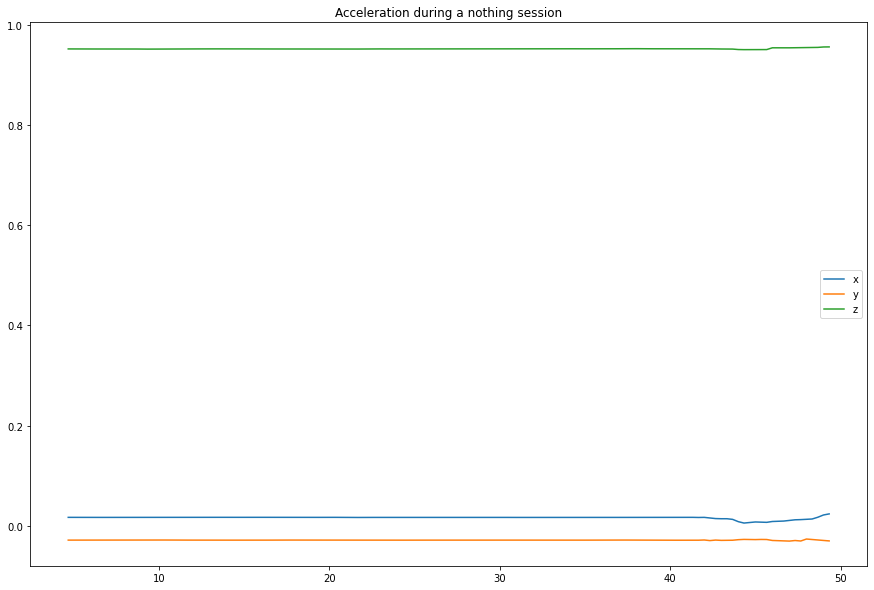

In [11]:
plt.rcParams['figure.figsize'] = (15, 10)
time = np.arange(nothing.shape[0])/3
_ = plt.plot(time, nothing.x.rolling(15).mean(), label="x")
_ = plt.plot(time, nothing.y.rolling(15).mean(), label="y")
_ = plt.plot(time, nothing.z.rolling(15).mean(), label="z")
_ = plt.legend()
_ = plt.title("Acceleration during a nothing session")

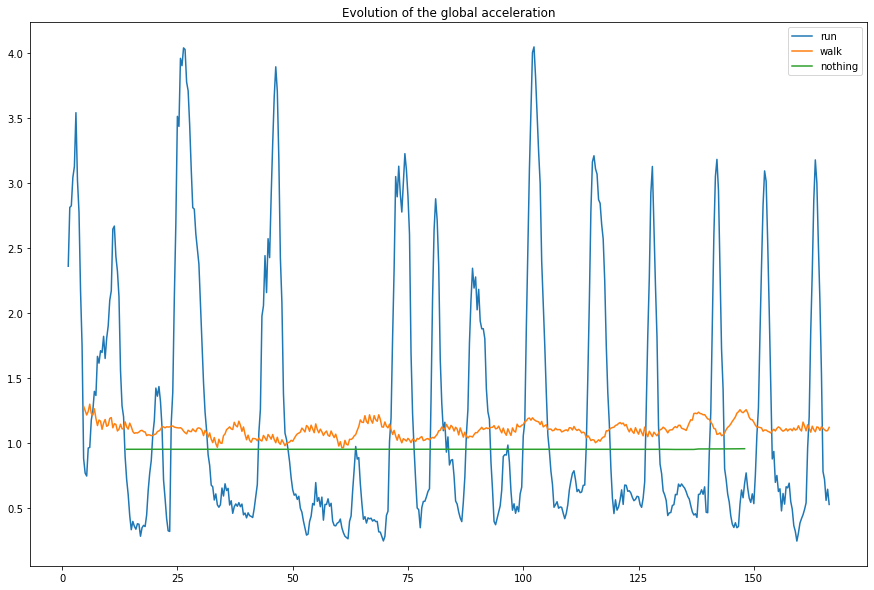

In [12]:
plt.plot(np.arange(500)/3, run.acceleration[500:1000].rolling(5).mean(), label="run")
plt.plot(np.arange(500)/3, walk.acceleration[500:1000].rolling(15).mean(), label="walk")
plt.plot(np.arange(nothing.acceleration.rolling(15).mean().shape[0]), nothing.acceleration.rolling(15).mean(), label="nothing")
plt.title("Evolution of the global acceleration")
plt.xlabel = "time"
plt.ylabel = "Acceleration (G)"
_ = plt.legend()

In [13]:

def kalman_filter(z, R=0.01**2, plot=True, display_range=None):
    """ Compute Kalman filter on a numpy array and plot the graph"""

    # intial parameters
    z = np.array(z)
    n_iter = z.shape[0]
    sz = (n_iter,) # size of array

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor


    # intial guesses
    xhat[0] = 0.0
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    plt.figure()
    if display_range is None:
        z2 = z
        xhat2 = xhat
        n = np.arange(n_iter)/3
    elif len(display_range)==2:
        z2 = z[display_range[0]:display_range[1]]
        xhat2 = xhat[display_range[0]:display_range[1]]
        n = np.arange(display_range[1]-display_range[0])/3
    else:
        raise ValueError("display_range must be a 2-uple")
    if plot == True:
        _ = plt.plot(n, z2,'k+',label='noisy measurements')
        _ = plt.plot(n, xhat2,'b-',label='a posteri estimate')
        _ = plt.legend()
        _ = plt.title('Acceleration over the time', fontweight='bold')
    return xhat


### Running

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

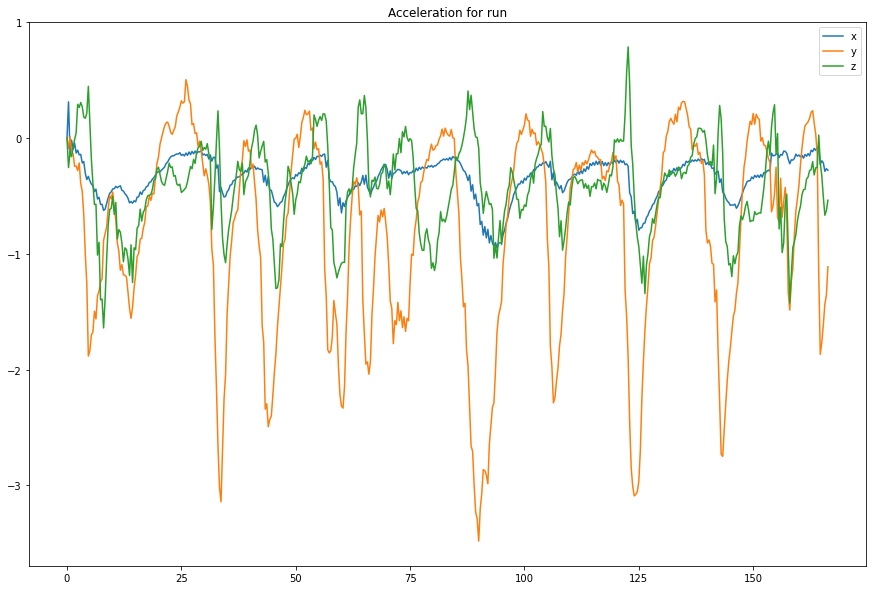

In [14]:
_ = [kalman_filter(run.x[1000:1500], R=0.05**2, plot=False), kalman_filter(run.y[1000:1500], R=0.01**2, plot=False), kalman_filter(run.z[1000:1500], R=0.01**2, plot=False)]
plt.plot(np.arange(500)/3, _[0], label="x")
plt.plot(np.arange(500)/3, _[1], label="y")
plt.plot(np.arange(500)/3, _[2], label="z")
plt.legend()
_ = plt.title('Acceleration for run')

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

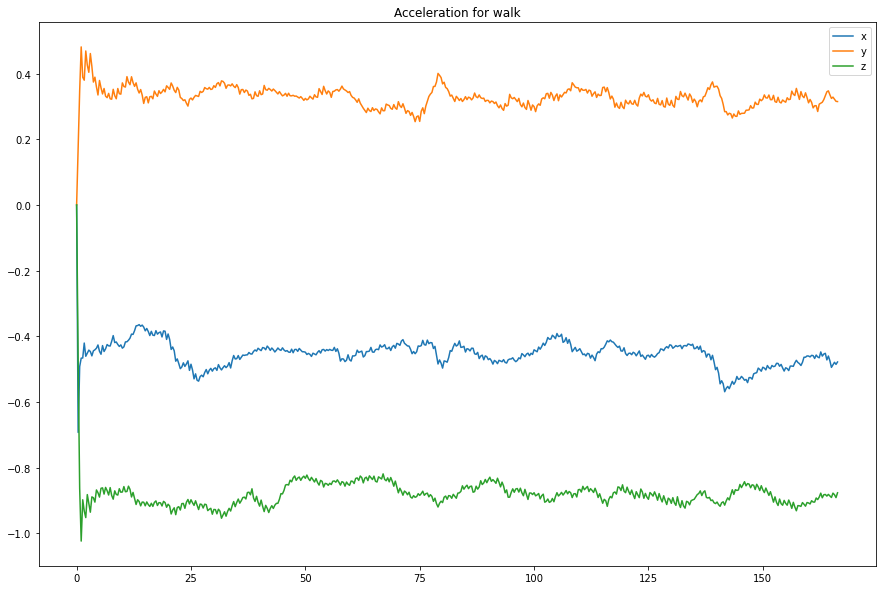

In [15]:
_ = [kalman_filter(walk.x[1000:1500], R=0.07**2, plot=False), kalman_filter(walk.y[1000:1500], R=0.07**2, plot=False), kalman_filter(walk.z[1000:1500], R=0.07**2, plot=False)]
plt.plot(np.arange(500)/3, _[0], label="x")
plt.plot(np.arange(500)/3, _[1], label="y")
plt.plot(np.arange(500)/3, _[2], label="z")
_ = plt.legend()
_ = plt.title('Acceleration for walk')

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

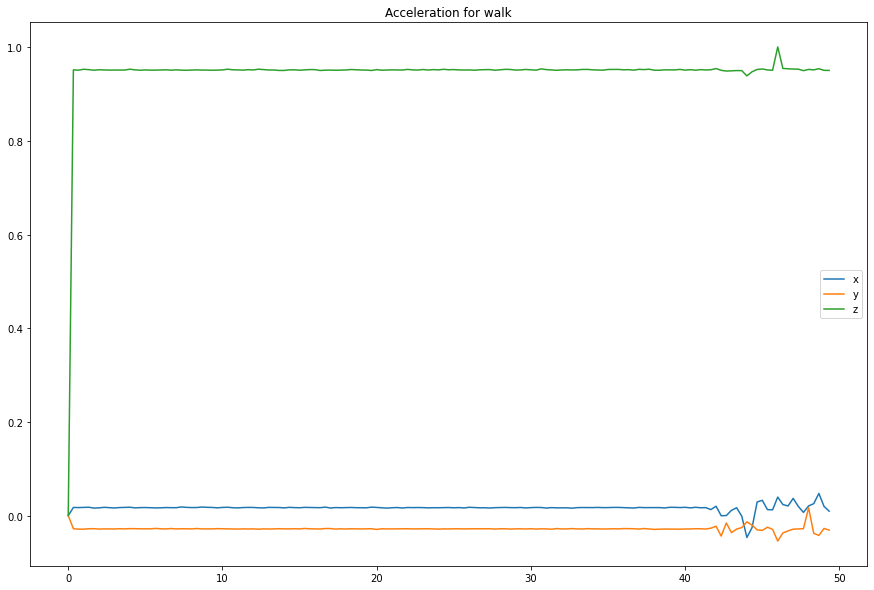

In [16]:
_ = [kalman_filter(nothing.x, R=0.001**2, plot=False), kalman_filter(nothing.y, R=0.001**2, plot=False), kalman_filter(nothing.z, R=0.001**2, plot=False)]
plt.plot(np.arange(149)/3, _[0], label="x")
plt.plot(np.arange(149)/3, _[1], label="y")
plt.plot(np.arange(149)/3, _[2], label="z")
plt.legend()
_ = plt.title('Acceleration for walk')

### Global acceleration

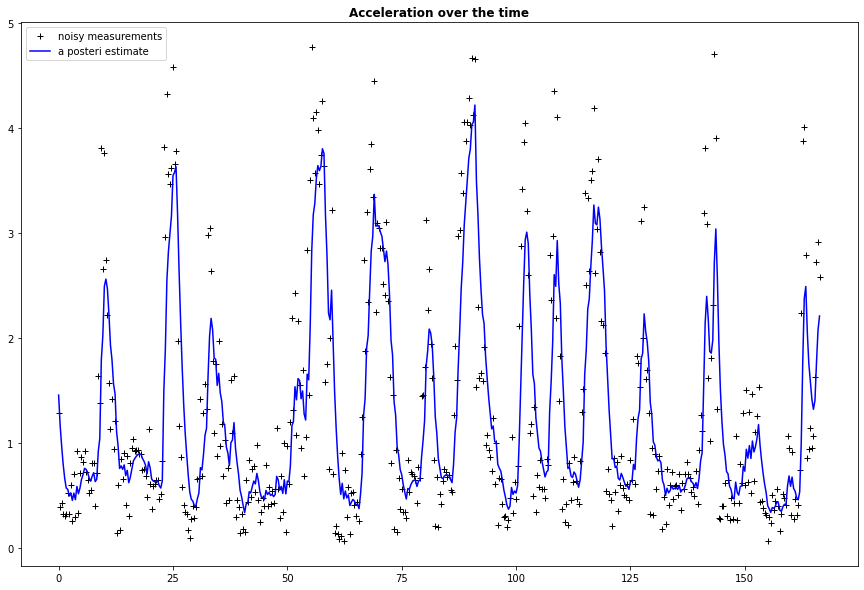

In [17]:
R = kalman_filter(run.acceleration, R=0.01**2, display_range=(1500,2000))

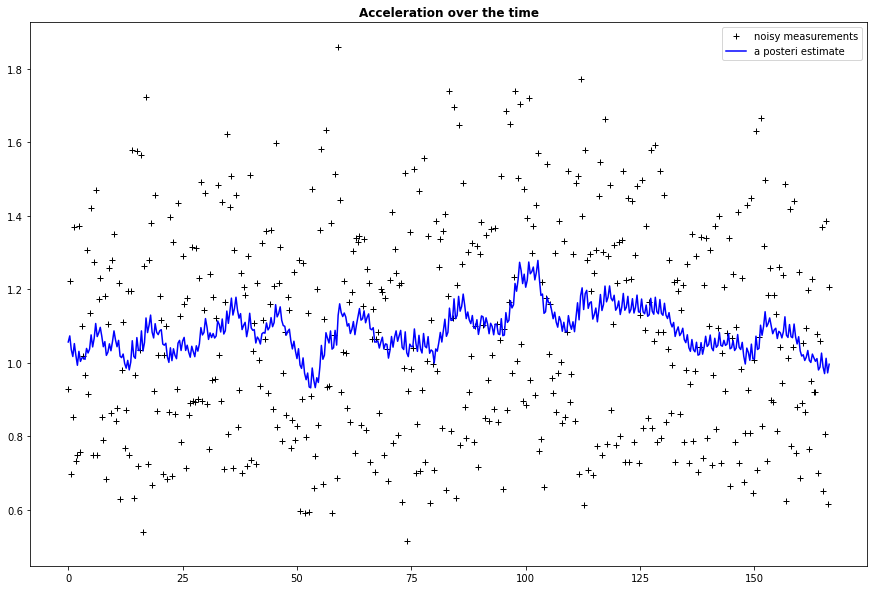

In [18]:
W = kalman_filter(walk.acceleration, R=0.03**2, display_range=(1500,2000))

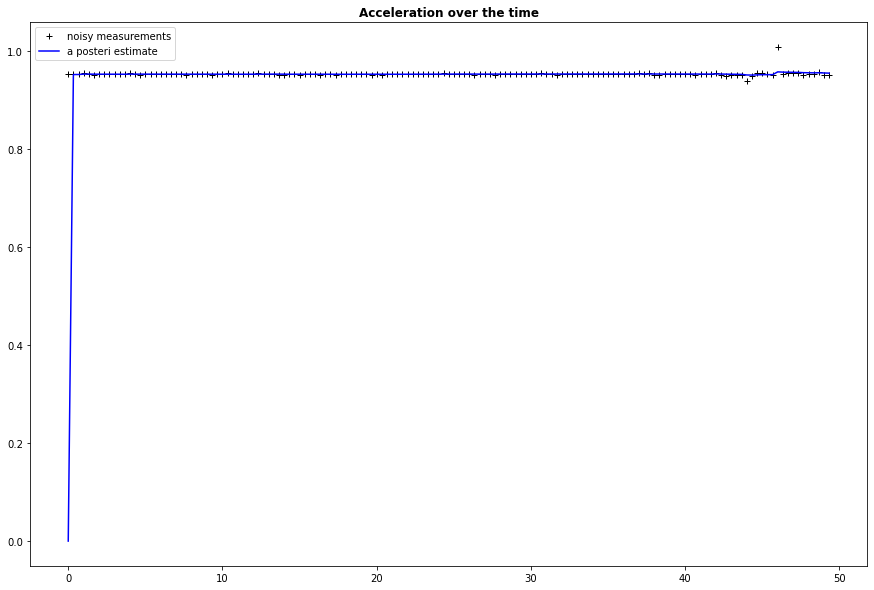

In [19]:
N = kalman_filter(nothing.acceleration, R=0.03**2, display_range=None)

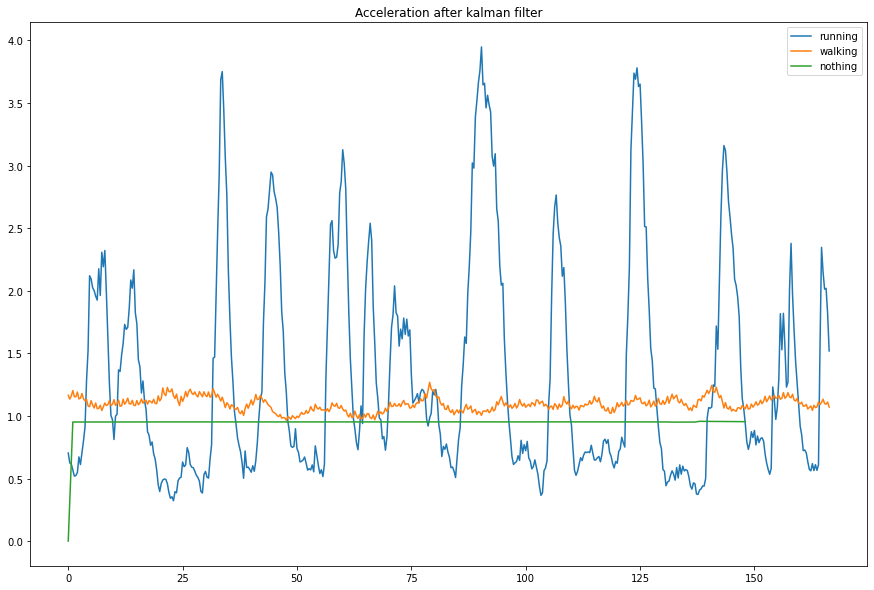

In [20]:
plt.plot(np.arange(500)/3, R[1000:1500], label="running")
plt.plot(np.arange(500)/3,W[1000:1500], label="walking")
plt.plot(N, label="nothing")
plt.legend()
_ = plt.title("Acceleration after kalman filter")